In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap



<h1>Read file</h1>

In [183]:
df = pd.read_csv(r'acs_demographic_data_by_census_tract.csv')
df = df.rename(columns= {'STATE' : 'STORE'})

<h1> Data manipulation</h1>

In [184]:
def generate_product_sales(row):
    relevant_columns = [
    'CENSUS_TRACT',
    'TOTAL_HOMES',
    'TOTAL_OWNED',
    'PCT_OWNED_OF_TOTAL',
    '15-34_pct_of_owned',
    '35-64_pct_of_owned',
    '65+_pct_of_owned',
    '2017+_pct_of_owned',
    '2015-16_pct_of_owned',
    '2010-14_pct_of_owned',
    '2000-09_pct_of_owned',
    '1990-99_pct_of_owned',
    '1989-_pct_of_owned',
    'MEDIAN_AGE_ALL_TOTAL',
    'MEDIAN_AGE_ALL_MALES',
    'MEDIAN_AGE_ALL_FEMALES',
    'MEDIAN_AGE_NATIVE_TOTAL',
    'MEDIAN_AGE_NATIVE_MALES',
    'MEDIAN_AGE_NATIVE_FEMALES',
    'MEDIAN_AGE_FOREIGN_BORN_TOTAL',
    'MEDIAN_AGE_FOREIGN_BORN_MALES',
    'MEDIAN_AGE_FOREIGN_BORN_FEMALES',
    'MEDIAN_AGE_WORKERS_TOTAL',
    'MEDIAN_AGE_WORKERS_MALES',
    'MEDIAN_AGE_WORKERS_FEMALES',
    'TOTAL_POPULATION',
    'TOTAL_INCOME',
    'TOTAL_INCOME_PER_CAP',
    'AVG_COMMUTE_IN_MINUTES',
    'PCT_VOTING_AGE_CITIZENS',
    'PCT_EMPLOYED',
    'PCT_MEN',
    'PCT_POVERTY_ALL',
    'PCT_POVERTY_CHILD',
    'FIELD_PCT_PROFESSIONAL',
    'FIELD_PCT_SERVICE',
    'FIELD_PCT_OFFICE',
    'FIELD_PCT_CONSTRUCTION',
    'FIELD_PCT_PRODUCTION',
    'COMMUTE_PCT_DRIVE',
    'COMMUTE_PCT_CARPOOL',
    'COMMUTE_PCT_TRANSIT',
    'COMMUTE_PCT_WALK',
    'COMMUTE_PCT_OTHER',
    'COMMUTE_PCT_WORK_FROM_HOME',
    'WORK_PCT_PRIVATE',
    'WORK_PCT_PUBLIC',
    'WORK_PCT_SELF_EMPLOYED',
    'WORK_PCT_UNEMPLOYED']
    # Randomly generate weights for each column
    weights = np.random.uniform(0, 0.1, len(relevant_columns))
    # Introduce different centers for each product category
    category_centers = [15000, 25000, 40000]  # You can customize these centers based on your needs
    center = category_centers[int(row['Product Category'])]
    
    sales = center + 0.1*np.random.normal(loc = row['TOTAL_INCOME'],scale = 0.05*row['TOTAL_INCOME']) +  np.random.normal(loc=0, scale=1000)
    return sales

In [190]:
numerical_states = np.linspace(0,49,50)
# Identify numeric columns for mean calculation
numeric_columns = df.select_dtypes(include='number').columns

# Group by 'Category' and calculate the mean for all numeric columns
grouped_df = df.groupby('STORE')[numeric_columns].mean().reset_index()

#Makes states numerical
grouped_df['STORE'] = numerical_states

#Add product categories and total sales
product_0_df = grouped_df.copy()
product_0_df['Product Category'] = 0
 

product_1_df = grouped_df.copy()
product_1_df['Product Category'] = 1

product_2_df = grouped_df.copy()
product_2_df['Product Category'] = 2

expanded_df = pd.concat([product_0_df, product_1_df, product_2_df], ignore_index=True)
expanded_df['Product Sales'] = expanded_df.apply(generate_product_sales, axis=1)

output_df = expanded_df.copy()
#df.loc[df['Product Category'] == 0]
output_df = output_df[output_df['Product Category'] ==0]

<h1>Data Cleaning</h1>

In [191]:
#Add outliers here
# List of the averages for the test. 
averages = [output_df[key].describe()['mean'] for key in df]
stds = [output_df[key].describe()['std'] for key in df]

indexes = output_df.index.tolist()
output_df.reindex(indexes)
# Adding the mean row to the bottom of the 
#print(output_df.at['51', 'Product Sales'])

i = 0
for key in output_df:
    if(key != 'Product Category' and key != 'Product Sales'):
        output_df.at[25, key] =  averages[i]+3*stds[i]    
        output_df.at[40, key] =  averages[i]-3*stds[i]
        i += 1

In [187]:

#Add 0 values, difficulty that can be explained is in terms of when are there NaN values, or 0. 
#The easy case done here is that all or none in a row is zero, if they are more sparse some sort of selection criteria is needed, which might be hard when columns differ
n_blank = 2
new_index = pd.RangeIndex(len(output_df)*(n_blank+1))
new_df = pd.DataFrame(0, index=new_index, columns=output_df.columns)
ids = np.arange(len(output_df))*(n_blank+1)
new_df.loc[ids] = output_df.values
output_df = new_df
output_df


,STORE,CENSUS_TRACT,TOTAL_HOMES,TOTAL_OWNED,PCT_OWNED_OF_TOTAL,15-34_pct_of_owned,35-64_pct_of_owned,65+_pct_of_owned,2017+_pct_of_owned,2015-16_pct_of_owned,...,COMMUTE_PCT_TRANSIT,COMMUTE_PCT_WALK,COMMUTE_PCT_OTHER,COMMUTE_PCT_WORK_FROM_HOME,WORK_PCT_PRIVATE,WORK_PCT_PUBLIC,WORK_PCT_SELF_EMPLOYED,WORK_PCT_UNEMPLOYED,Product Category,Product Sales
0,0.0,2.103886e+09,1526.879518,976.939759,0.636919,0.115852,0.630658,0.247469,0.021836,0.073942,...,0.013861,0.108794,0.066630,0.054352,0.650230,0.276291,0.071267,0.087006,0.0,20478.883098
1,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,1.0,1.076296e+09,1584.556218,1086.220613,0.669051,0.097264,0.557303,0.342026,0.019612,0.057928,...,0.005649,0.014106,0.011932,0.028429,0.791606,0.154592,0.051779,0.086445,0.0,18201.118515
4,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
146,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
147,49.0,5.602201e+10,1760.534351,1222.297710,0.689830,0.135243,0.571248,0.293531,0.024266,0.085899,...,0.012443,0.043802,0.019824,0.049649,0.712511,0.217534,0.066824,0.049145,0.0,21185.871509
148,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


<h3>Removing NaN/Null/zero values</h3>

In [192]:
output_df = output_df.loc[(output_df!=0).any(axis=1)]

In [194]:
output_df.mean()

STORE                              2.418000e+01
CENSUS_TRACT                       2.904180e+10
TOTAL_HOMES                        1.649561e+03
TOTAL_OWNED                        1.086559e+03
PCT_OWNED_OF_TOTAL                 6.536133e-01
15-34_pct_of_owned                 1.048858e-01
35-64_pct_of_owned                 5.791384e-01
65+_pct_of_owned                   3.113663e-01
2017+_pct_of_owned                 2.318504e-02
2015-16_pct_of_owned               6.674611e-02
2010-14_pct_of_owned               1.926127e-01
2000-09_pct_of_owned               3.094288e-01
1990-99_pct_of_owned               1.846097e-01
1989-_pct_of_owned                 2.188082e-01
MEDIAN_AGE_ALL_TOTAL               3.957695e+01
MEDIAN_AGE_ALL_MALES               3.843318e+01
MEDIAN_AGE_ALL_FEMALES             4.072187e+01
MEDIAN_AGE_NATIVE_TOTAL            3.853315e+01
MEDIAN_AGE_NATIVE_MALES            3.746112e+01
MEDIAN_AGE_NATIVE_FEMALES          3.969571e+01
MEDIAN_AGE_FOREIGN_BORN_TOTAL      4.363

<h3>Removing Outliers</h3>

In [197]:
output_df = output_df[np.abs(output_df-output_df.mean()) <= (3*output_df.std())]
output_df = output_df.dropna()
output_df

,STORE,CENSUS_TRACT,TOTAL_HOMES,TOTAL_OWNED,PCT_OWNED_OF_TOTAL,15-34_pct_of_owned,35-64_pct_of_owned,65+_pct_of_owned,2017+_pct_of_owned,2015-16_pct_of_owned,...,COMMUTE_PCT_TRANSIT,COMMUTE_PCT_WALK,COMMUTE_PCT_OTHER,COMMUTE_PCT_WORK_FROM_HOME,WORK_PCT_PRIVATE,WORK_PCT_PUBLIC,WORK_PCT_SELF_EMPLOYED,WORK_PCT_UNEMPLOYED,Product Category,Product Sales
1,1.0,1.076296e+09,1584.556218,1086.220613,0.669051,0.097264,0.557303,0.342026,0.019612,0.057928,...,0.005649,0.014106,0.011932,0.028429,0.791606,0.154592,0.051779,0.086445,0,19987.778662
2,2.0,5.078776e+09,1682.007299,1104.278832,0.656161,0.107399,0.554982,0.336160,0.022264,0.065239,...,0.004839,0.019504,0.013866,0.032213,0.771636,0.163350,0.063051,0.070397,0,18288.038916
3,3.0,4.015045e+09,1667.305152,1060.809115,0.633189,0.106052,0.560005,0.330640,0.032598,0.089204,...,0.020162,0.021880,0.027351,0.061496,0.787521,0.146864,0.063956,0.075952,0,20526.037909
5,5.0,8.046807e+09,1711.244534,1110.238866,0.656676,0.121616,0.597288,0.275427,0.029769,0.089095,...,0.030431,0.029455,0.022673,0.073992,0.791317,0.139890,0.066769,0.054822,0,23283.643772
6,6.0,9.005841e+09,1653.414752,1096.897219,0.649788,0.083743,0.613571,0.296638,0.018622,0.055981,...,0.056331,0.032979,0.011909,0.048723,0.807082,0.127323,0.063745,0.077498,0,23388.240749
7,7.0,1.000322e+10,1671.799065,1188.355140,0.698970,0.094977,0.566909,0.338110,0.023747,0.062862,...,0.036178,0.028131,0.012822,0.047832,0.817103,0.140589,0.041173,0.066019,0,20984.971418
9,9.0,1.313286e+10,1899.379416,1198.146953,0.616786,0.099863,0.594852,0.299652,0.025872,0.068755,...,0.025411,0.018549,0.018186,0.047833,0.788939,0.153616,0.055872,0.081851,0,20928.328102
11,11.0,1.910980e+10,1527.162819,1086.454435,0.712581,0.134587,0.563287,0.300910,0.022003,0.067080,...,0.010176,0.035215,0.015094,0.047151,0.798549,0.128499,0.070769,0.043791,0,20835.014359
13,13.0,1.707840e+10,1550.573997,1023.767255,0.642941,0.104394,0.594803,0.296951,0.020628,0.060544,...,0.105272,0.031027,0.018346,0.043566,0.827202,0.123893,0.047423,0.084897,0,22338.901766
14,14.0,1.808914e+10,1696.889037,1169.921595,0.670090,0.119733,0.575874,0.300406,0.022711,0.066574,...,0.014308,0.023476,0.015744,0.033713,0.847073,0.104899,0.046457,0.069022,0,20675.030732


<h1>Data correlation exploration</h1>

In [198]:
corr = output_df.corr()
corr.style.background_gradient(cmap='coolwarm')

c:\Users\etonseth\AppData\Local\anaconda3\lib\site-packages\pandas\io\formats\style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\etonseth\AppData\Local\anaconda3\lib\site-packages\pandas\io\formats\style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,STORE,CENSUS_TRACT,TOTAL_HOMES,TOTAL_OWNED,PCT_OWNED_OF_TOTAL,15-34_pct_of_owned,35-64_pct_of_owned,65+_pct_of_owned,2017+_pct_of_owned,2015-16_pct_of_owned,2010-14_pct_of_owned,2000-09_pct_of_owned,1990-99_pct_of_owned,1989-_pct_of_owned,MEDIAN_AGE_ALL_TOTAL,MEDIAN_AGE_ALL_MALES,MEDIAN_AGE_ALL_FEMALES,MEDIAN_AGE_NATIVE_TOTAL,MEDIAN_AGE_NATIVE_MALES,MEDIAN_AGE_NATIVE_FEMALES,MEDIAN_AGE_FOREIGN_BORN_TOTAL,MEDIAN_AGE_FOREIGN_BORN_MALES,MEDIAN_AGE_FOREIGN_BORN_FEMALES,MEDIAN_AGE_WORKERS_TOTAL,MEDIAN_AGE_WORKERS_MALES,MEDIAN_AGE_WORKERS_FEMALES,TOTAL_POPULATION,TOTAL_INCOME,TOTAL_INCOME_PER_CAP,AVG_COMMUTE_IN_MINUTES,PCT_VOTING_AGE_CITIZENS,PCT_EMPLOYED,PCT_MEN,PCT_POVERTY_ALL,PCT_POVERTY_CHILD,FIELD_PCT_PROFESSIONAL,FIELD_PCT_SERVICE,FIELD_PCT_OFFICE,FIELD_PCT_CONSTRUCTION,FIELD_PCT_PRODUCTION,COMMUTE_PCT_DRIVE,COMMUTE_PCT_CARPOOL,COMMUTE_PCT_TRANSIT,COMMUTE_PCT_WALK,COMMUTE_PCT_OTHER,COMMUTE_PCT_WORK_FROM_HOME,WORK_PCT_PRIVATE,WORK_PCT_PUBLIC,WORK_PCT_SELF_EMPLOYED,WORK_PCT_UNEMPLOYED,Product Category,Product Sales
STORE,1.000000,0.994285,0.077216,0.058046,0.018973,-0.204413,0.087472,0.038846,-0.134303,-0.147352,-0.243471,-0.097953,0.079696,0.213901,0.261545,0.280167,0.240287,0.222519,0.251976,0.192651,0.187512,0.168018,0.180164,0.138833,0.140575,0.140155,-0.013462,0.000348,0.006052,0.026730,0.190613,0.107291,0.158250,-0.095711,-0.097011,0.039986,0.049564,-0.191629,0.103666,-0.064729,-0.052818,-0.006329,-0.043235,0.284770,-0.000721,0.058009,-0.142173,0.111696,0.112309,-0.190220,nan,-0.058877
CENSUS_TRACT,0.994285,1.000000,0.099242,0.077648,0.010645,-0.177217,0.097521,0.011556,-0.127362,-0.140834,-0.239186,-0.099901,0.074514,0.210960,0.252717,0.272120,0.231521,0.218877,0.246654,0.190416,0.155104,0.142537,0.150156,0.127421,0.132950,0.125410,0.000258,0.005981,0.012893,0.021406,0.186285,0.124277,0.152227,-0.104725,-0.107053,0.044638,0.033372,-0.225278,0.091028,-0.049201,-0.054763,-0.013256,-0.036868,0.286851,-0.009354,0.054349,-0.126048,0.096921,0.105538,-0.202202,nan,-0.062399
TOTAL_HOMES,0.077216,0.099242,1.000000,0.828307,-0.435990,-0.237854,0.321872,-0.157175,0.512899,0.460088,0.164863,0.521481,-0.177299,-0.461696,-0.102296,-0.064697,-0.138452,-0.180377,-0.155200,-0.214802,0.113570,0.133469,0.114557,-0.057585,-0.035049,-0.057182,0.929053,0.199740,0.188265,0.317250,-0.211062,0.019226,-0.057742,-0.056801,-0.043231,0.159087,-0.081430,0.133123,-0.163396,-0.132259,-0.217692,0.178812,0.107488,-0.083872,0.370200,0.247269,0.049484,-0.051864,0.005935,0.096485,nan,0.044709
TOTAL_OWNED,0.058046,0.077648,0.828307,1.000000,0.101299,-0.208257,0.178228,-0.000392,0.301504,0.301664,0.014926,0.352911,-0.000005,-0.252605,0.173722,0.195743,0.148189,0.196682,0.206142,0.173493,-0.023699,-0.032353,-0.038748,0.165277,0.170047,0.173327,0.693172,0.087116,0.096564,0.235822,0.154510,0.007355,-0.096413,-0.083099,-0.050904,0.062602,-0.173991,0.076648,-0.140632,0.029569,0.007976,0.010878,-0.061932,-0.132513,0.106915,0.189851,0.087394,-0.060012,-0.081762,0.025150,nan,0.034536
PCT_OWNED_OF_TOTAL,0.018973,0.010645,-0.435990,0.101299,1.000000,0.158311,-0.249320,0.198476,-0.264626,-0.136105,-0.105077,-0.254926,0.213767,0.225825,0.508196,0.504603,0.507575,0.657102,0.658880,0.658458,-0.177812,-0.229991,-0.195273,0.413599,0.360253,0.437108,-0.556722,-0.137114,-0.105173,-0.254084,0.563218,0.090158,0.181142,-0.169877,-0.151166,-0.053812,-0.260460,-0.240421,0.154221,0.157882,0.274865,-0.196593,-0.312043,0.055779,-0.377260,0.120730,-0.101847,0.068146,0.102032,-0.320508,nan,0.050880
15-34_pct_of_owned,-0.204413,-0.177217,-0.237854,-0.208257,0.158311,1.000000,-0.341845,-0.346702,0.358374,0.395867,0.636507,-0.115253,-0.500290,-0.369579,-0.541508,-0.497724,-0.558069,-0.303919,-0.260470,-0.320354,-0.655585,-0.624442,-0.659316,-0.611784,-0.610840,-0.624716,-0.280296,-0.245763,-0.292595,-0.644671,-0.187424,0.122860,0.585663,0.028062,0.008054,-0.290879,-0.289939,-0.147417,0.313695,0.368604,0.306226,0.245641,-0.365255,-0.258223,-0.061448,-0.005143,0.082090,-0.150345,0.149915,-0.

In [199]:
output_df.var()

STORE                              2.057988e+02
CENSUS_TRACT                       2.413435e+20
TOTAL_HOMES                        1.924264e+04
TOTAL_OWNED                        6.427663e+03
PCT_OWNED_OF_TOTAL                 1.032490e-03
15-34_pct_of_owned                 2.044368e-04
35-64_pct_of_owned                 4.309324e-04
65+_pct_of_owned                   4.721719e-04
2017+_pct_of_owned                 1.391793e-05
2015-16_pct_of_owned               9.845549e-05
2010-14_pct_of_owned               4.426138e-04
2000-09_pct_of_owned               2.285025e-04
1990-99_pct_of_owned               6.393550e-05
1989-_pct_of_owned                 1.284446e-03
MEDIAN_AGE_ALL_TOTAL               2.533489e+00
MEDIAN_AGE_ALL_MALES               2.497445e+00
MEDIAN_AGE_ALL_FEMALES             2.538648e+00
MEDIAN_AGE_NATIVE_TOTAL            3.545070e+00
MEDIAN_AGE_NATIVE_MALES            3.337399e+00
MEDIAN_AGE_NATIVE_FEMALES          3.522727e+00
MEDIAN_AGE_FOREIGN_BORN_TOTAL      5.032

<h1>SkLearn Object Init</h1>

In [200]:
#Init sklearn objects
Sc = StandardScaler()
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init='auto',
    max_iter=3000
)
#Run pca to find plottable data
pca = PCA(n_components=3)

#Fit pandas dataframe
X = Sc.fit_transform(output_df)

<h1>Fit data and plot</h1>

In [201]:
#Fit PCA and kmeans
kmeans.fit(X)
pca_data = pd.DataFrame(pca.fit_transform(X), columns=['PC1','PC2', 'PC3'])
pca_data['cluster'] = pd.Categorical(kmeans.labels_)

c:\Users\etonseth\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [202]:
#Plot PCA vs clusters
#sns.scatterplot(x='PC1',y='PC2',hue='cluster',data=pca_data)


In [203]:
%matplotlib tk
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure= False)
fig.add_axes(ax)

sc = ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], s = 40, alpha = 1, c= pca_data['cluster'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

<h1>DBSCAN HERE</h1>

In [204]:
dbscan = DBSCAN(eps = 5.25, min_samples= 2).fit(X)
pca_data['cluster'] = pd.Categorical(dbscan.labels_)

In [205]:
%matplotlib tk
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure= False)
fig.add_axes(ax)

sc = ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], s = 40, alpha = 1, c= pca_data['cluster'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

An issue with DBSCAN: optimal epsilon selection when data contains clusters of varying density 
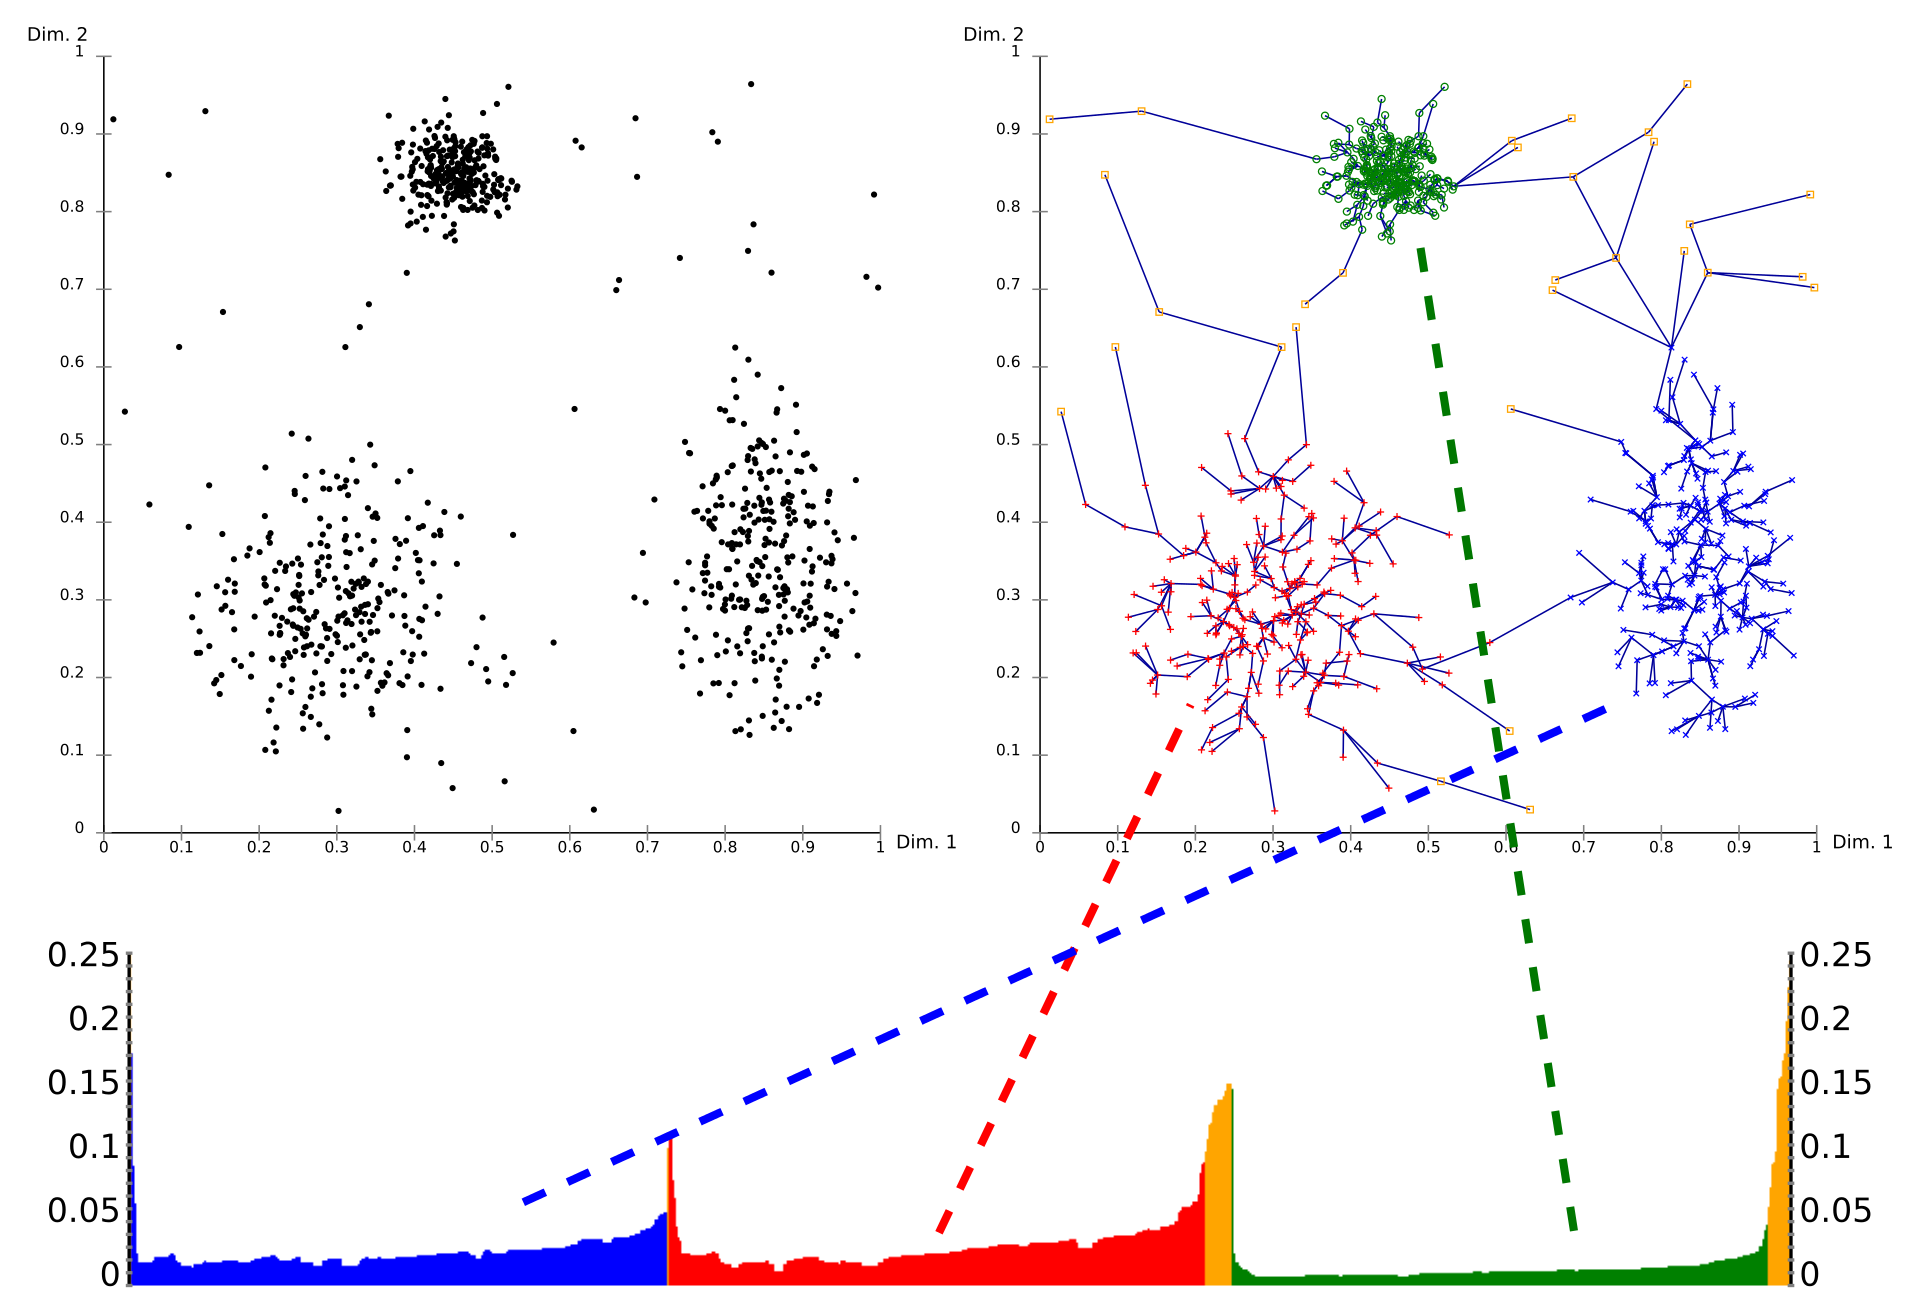

<h1>OPTICS</h1>
A method that tries to take into account that clusters may have varying density

In [206]:
optics = OPTICS(min_samples=2).fit(X)
pca_data['cluster'] = pd.Categorical(dbscan.labels_)

In [207]:
%matplotlib tk
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure= False)
fig.add_axes(ax)

sc = ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], s = 40, alpha = 1, c= pca_data['cluster'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()